In [1]:
import akida
import numpy as np
from akida_models.imagenet import get_preprocessed_samples

# Model specification and hyperparameters
NUM_CHANNELS = 3
IMAGE_SIZE = 224

# Load the preprocessed images and their corresponding labels for the test set
x_test, labels_test = get_preprocessed_samples(IMAGE_SIZE, NUM_CHANNELS)
print(f'{x_test.shape[0]} images and their labels are loaded and preprocessed.')

10 images and their labels are loaded and preprocessed.


In [2]:
from cnn2snn import set_akida_version, AkidaVersion
from akida_models import akidanet_imagenet_pretrained

# Use a quantized model with pretrained quantized weights
with set_akida_version(AkidaVersion.v1):
    model_keras_quantized_pretrained = akidanet_imagenet_pretrained(0.5)
model_keras_quantized_pretrained.summary()

C:\Users\msaad\AppData\Roaming\Python\Python38\site-packages\akida_models\model_io.py:124: UserWarning: Model akidanet_imagenet_224_alpha_50_iq8_wq4_aq4.h5 has been trained with akida_models 1.1.10 which is the last version supporting 1.0 models training
  warnings.warn(f'Model {model_name_v1} has been trained with akida_models 1.1.10 which is '


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv_0 (QuantizedConv2D)    (None, 112, 112, 16)      448       
                                                                 
 conv_0/relu (QuantizedReLU)  (None, 112, 112, 16)     0         
                                                                 
 conv_1 (QuantizedConv2D)    (None, 112, 112, 32)      4640      
                                                                 
 conv_1/relu (QuantizedReLU)  (None, 112, 112, 32)     0         
                                                                 
 conv_2 (QuantizedConv2D)    (None, 56, 56, 64)        18496     
                                                                 
 conv_2/relu (QuantizedReLU)  (None, 56, 56, 64)      

In [3]:
from timeit import default_timer as timer

num_images = len(x_test)

start = timer()
potentials_keras = model_keras_quantized_pretrained.predict(x_test, batch_size=100)
end = timer()
print(f'Keras inference on {num_images} images took {end-start:.2f} s.\n')

preds_keras = np.squeeze(np.argmax(potentials_keras, 1))
accuracy_keras = np.sum(np.equal(preds_keras, labels_test)) / num_images
print(f"Keras accuracy: {accuracy_keras*num_images:.0f}/{num_images}.")

1/1 [==============================] - 1s 745ms/step
Keras inference on 10 images took 0.79 s.

Keras accuracy: 9/10.


In [4]:
from cnn2snn import convert

model_akida = convert(model_keras_quantized_pretrained)

model_akida.summary()

                 Model Summary                  
________________________________________________
Input shape    Output shape  Sequences  Layers
[224, 224, 3]  [1, 1, 1000]  1          15    
________________________________________________

_____________________________________________________________
Layer (type)              Output shape    Kernel shape     

============== SW/conv_0-classifier (Software) ==============

conv_0 (InputConv.)       [112, 112, 16]  (3, 3, 3, 16)    
_____________________________________________________________
conv_1 (Conv.)            [112, 112, 32]  (3, 3, 16, 32)   
_____________________________________________________________
conv_2 (Conv.)            [56, 56, 64]    (3, 3, 32, 64)   
_____________________________________________________________
conv_3 (Conv.)            [56, 56, 64]    (3, 3, 64, 64)   
_____________________________________________________________
separable_4 (Sep.Conv.)   [28, 28, 128]   (3, 3, 64, 1)    
________________________

In [5]:
# Check Model performance
start = timer()
accuracy_akida = model_akida.evaluate(x_test, labels_test)
end = timer()
print(f'Inference on {num_images} images took {end-start:.2f} s.\n')
print(f"Accuracy: {accuracy_akida*num_images:.0f}/{num_images}.")

# For non-regression purposes
assert accuracy_akida >= 0.8

Inference on 10 images took 0.13 s.

Accuracy: 8/10.


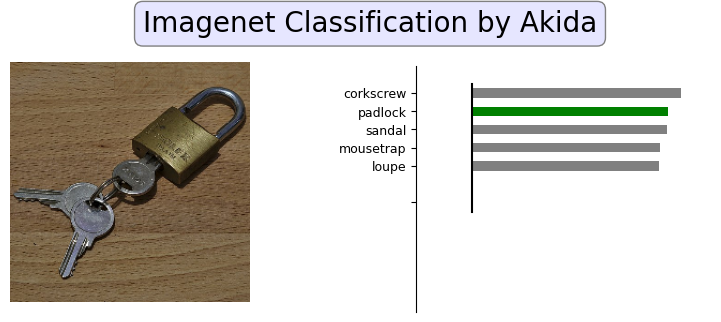

In [6]:
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from akida_models.imagenet import preprocessing


# Functions used to display the top5 results
def get_top5(potentials, true_label):
    """
    Returns the top 5 classes from the output potentials
    """
    tmp_pots = potentials.copy()
    top5 = []
    min_val = np.min(tmp_pots)
    for ii in range(5):
        best = np.argmax(tmp_pots)
        top5.append(best)
        tmp_pots[best] = min_val

    vals = np.zeros((6,))
    vals[:5] = potentials[top5]
    if true_label not in top5:
        vals[5] = potentials[true_label]
    else:
        vals[5] = 0
    vals /= np.max(vals)

    class_name = []
    for ii in range(5):
        class_name.append(preprocessing.index_to_label(top5[ii]).split(',')[0])
    if true_label in top5:
        class_name.append('')
    else:
        class_name.append(
            preprocessing.index_to_label(true_label).split(',')[0])

    return top5, vals, class_name


def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
        else:
            spine.set_color('none')  # don't draw spine
    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])


def prepare_plots():
    fig = plt.figure(figsize=(8, 4))
    # Image subplot
    ax0 = plt.subplot(1, 3, 1)
    imgobj = ax0.imshow(np.zeros((IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS), dtype=np.uint8))
    ax0.set_axis_off()
    # Top 5 results subplot
    ax1 = plt.subplot(1, 2, 2)
    bar_positions = (0, 1, 2, 3, 4, 6)
    rects = ax1.barh(bar_positions, np.zeros((6,)), align='center', height=0.5)
    plt.xlim(-0.2, 1.01)
    ax1.set(xlim=(-0.2, 1.15), ylim=(-1.5, 12))
    ax1.set_yticks(bar_positions)
    ax1.invert_yaxis()
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks([])
    adjust_spines(ax1, 'left')
    ax1.add_line(lines.Line2D((0, 0), (-0.5, 6.5), color=(0.0, 0.0, 0.0)))
    # Adjust Plot Positions
    ax0.set_position([0.05, 0.055, 0.3, 0.9])
    l1, b1, w1, h1 = ax1.get_position().bounds
    ax1.set_position([l1 * 1.05, b1 + 0.09 * h1, w1, 0.8 * h1])
    # Add title box
    plt.figtext(0.5,
                0.9,
                "Imagenet Classification by Akida",
                size=20,
                ha="center",
                va="center",
                bbox=dict(boxstyle="round",
                          ec=(0.5, 0.5, 0.5),
                          fc=(0.9, 0.9, 1.0)))

    return fig, imgobj, ax1, rects


def update_bars_chart(rects, vals, true_label):
    counter = 0
    for rect, h in zip(rects, yvals):
        rect.set_width(h)
        if counter < 5:
            if top5[counter] == true_label:
                if counter == 0:
                    rect.set_facecolor((0.0, 1.0, 0.0))
                else:
                    rect.set_facecolor((0.0, 0.5, 0.0))
            else:
                rect.set_facecolor('gray')
        elif counter == 5:
            rect.set_facecolor('red')
        counter += 1


# Prepare plots
fig, imgobj, ax1, rects = prepare_plots()

# Get a random image
img = np.random.randint(num_images)

# Predict image class
outputs_akida = model_akida.predict(np.expand_dims(x_test[img], axis=0)).squeeze()

# Get top 5 prediction labels and associated names
true_label = labels_test[img]
top5, yvals, class_name = get_top5(outputs_akida, true_label)

# Draw Plots
imgobj.set_data(x_test[img])
ax1.set_yticklabels(class_name, rotation='horizontal', size=9)
update_bars_chart(rects, yvals, true_label)
fig.canvas.draw()
plt.show()